In [1]:
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\LAKSHMI SRI
[nltk_data]     LASYA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\LAKSHMI SRI
[nltk_data]     LASYA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\LAKSHMI SRI
[nltk_data]     LASYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import json
dataList = []
sentences = []
labels = []
def loadDataset(filename):
  d=[]
  with open(filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    d.append([sentence,label])
  return d
# Loading both sensitive and non-sensitive dataset
sen=loadDataset("SensitiveDataset.json")
nonsen=loadDataset("NonSensitiveDatasetnew.json")
sen=pd.DataFrame(data=sen,columns=['sentences','labels'])
nonsen=pd.DataFrame(data=nonsen,columns=['sentences','labels'])

In [3]:
combined = pd.concat([sen, nonsen])
df = combined.sample(frac=1).reset_index(drop=True)
df.head()

,sentences,labels
0,"thuy, parents, thuy@yandex.ru, 7361055506",1
1,Irene Vail (Jean Arthur) decides to divorce he...,0
2,"faiz, livestrong, faiz@aliceadsl.fr, 90...",1
3,"ben, fabian, ben@bol.com.br, 9242003403",1
4,The film opens in late 1950s Los Angeles at a ...,0


In [4]:
tokenized_data = [word_tokenize(sentence) for sentence in df['sentences']]
stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
punctuations.remove('@')
stop_words.update(punctuations)
stemmer = PorterStemmer()
filtered_data = [[stemmer.stem(word) for word in sentence if word.lower() not in stop_words] for sentence in tokenized_data]
l=[]
for idx, sentence in enumerate(filtered_data):
    l.append(' '.join(sentence))
df['sentences'] = l

In [6]:
df.head() 

,sentences,labels
0,thuy parent thuy @ yandex.ru 7361055506,1
1,iren vail jean arthur decid divorc husband ric...,0
2,faiz livestrong faiz @ aliceadsl.fr 9065928833,1
3,ben fabian ben @ bol.com.br 9242003403,1
4,film open late 1950 lo angel quiet pot-luck wa...,0


In [7]:
df_train = df.sample(frac=.8, random_state=11)
df_test = df.drop(df_train.index)
print(df_train.shape, df_test.shape)

(25261, 2) (6315, 2)


In [8]:
y_train = df_train['labels'].values
y_test = df_test['labels'].values
y_test.shape

(6315,)

In [9]:
X_train = df_train['sentences'].values
X_test = df_test['sentences'].values

In [10]:
source=len(X_train)
max_len= max(len(seq) for seq in X_train)
print(source,max_len)

25261 14225


In [11]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_dict = tokenizer.index_word

In [12]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
print(X_train_seq[:5])
print(df_train.iloc[0,:])
for el in X_train_seq[0]:
    print(word_dict[el], end=' ')

[[1403, 47207, 1403, 48, 448, 1379, 47208], [35488, 2712, 35488, 4789, 1195, 47209], [1708, 382, 7105, 77, 8355, 375, 224, 183, 1778, 619, 142, 54, 397, 646, 272, 1260, 37, 969, 359, 4627, 1367, 135, 1778, 90, 83, 272, 206, 49, 9, 135, 1198, 559, 4, 380, 26, 30, 1783, 3933, 119, 7, 290, 272, 19, 13033, 206, 272, 1784, 2885, 1754, 411, 2655, 302, 635, 1778, 2, 238, 34, 56, 154, 19, 1629, 5046, 2674, 4, 700, 1960, 45, 407, 349, 120, 3175, 4094, 3146, 560, 1372, 605, 648], [999, 711, 1794, 374, 52, 12, 89, 104, 3838, 1067, 34, 2971, 360, 969, 667, 2461, 777, 139, 663, 1733, 745, 9017, 1794, 4436, 168, 482, 1323, 1522, 12, 360, 6749, 1733, 201, 1131, 745, 2148, 539, 3412, 1522, 283, 1068, 1794, 2, 950, 20028, 1794, 37, 108, 202, 2461, 166, 1260, 745, 115, 111, 1794, 637, 287, 201, 613, 90, 435, 115, 50, 892, 1870, 1067, 2461, 210, 3735, 860, 1323, 1676, 1023, 3635, 2599, 12, 166, 8, 54, 97, 65, 35, 1794, 955, 351, 20, 1794, 1013, 103, 201, 207, 97, 65, 463, 196, 3350, 287, 932, 3075, 15944

In [13]:
X_train_pad = pad_sequences(X_train_seq, maxlen=20, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=20, padding='post')
X_train_pad[:5]
X_train_pad.shape[0]
#get max number in X_train_pad and X_test_pad
max_num=max([max(seq) for seq in X_train_pad])
max_num

81659

In [14]:
X_test_pad.shape

(6315, 20)

In [24]:
from keras.regularizers import l1
from keras.constraints import max_norm
lstm_model1 = Sequential()
lstm_model1.add(Embedding(max_num+1,64, input_length=X_train_pad.shape[1]))
lstm_model1.add(LSTM(400,kernel_regularizer=l1(0.01),kernel_constraint=max_norm(2.)))
lstm_model1.add(Dense(1, activation='sigmoid'))

lstm_model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 64)            5226240   
                                                                 
 lstm_1 (LSTM)               (None, 400)               744000    
                                                                 
 dense_1 (Dense)             (None, 1)                 401       
                                                                 
Total params: 5970641 (22.78 MB)
Trainable params: 5970641 (22.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
history1 = lstm_model1.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/10
395/395 [==============================] - 32s 74ms/step - loss: 1.8943 - accuracy: 0.9873 - val_loss: 0.1407 - val_accuracy: 0.9984
Epoch 2/10
395/395 [==============================] - 33s 84ms/step - loss: 0.1390 - accuracy: 0.9992 - val_loss: 0.1336 - val_accuracy: 0.9990
Epoch 3/10
395/395 [==============================] - 33s 85ms/step - loss: 0.1369 - accuracy: 0.9992 - val_loss: 0.1364 - val_accuracy: 0.9990
Epoch 4/10
395/395 [==============================] - 35s 87ms/step - loss: 0.1252 - accuracy: 0.9999 - val_loss: 0.1528 - val_accuracy: 0.9989
Epoch 5/10
395/395 [==============================] - 41s 103ms/step - loss: 0.1393 - accuracy: 0.9997 - val_loss: 0.1353 - val_accuracy: 0.9992
Epoch 6/10
395/395 [==============================] - 34s 86ms/step - loss: 0.1265 - accuracy: 0.9999 - val_loss: 0.1336 - val_accuracy: 0.9984
Epoch 7/10
395/395 [==============================] - 33s 85ms/step - loss: 0.1234 - accuracy: 0.9998 - val_loss: 0.1560 - val_accuracy

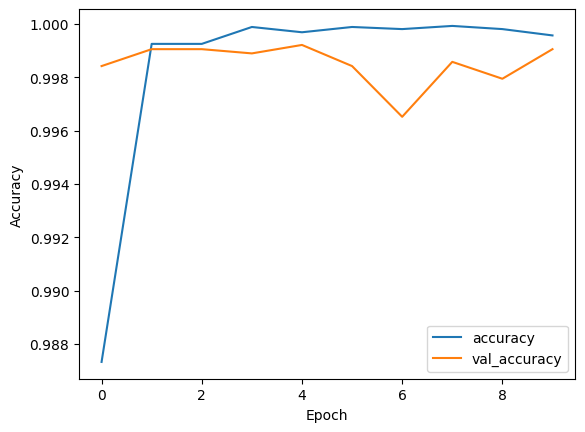

In [26]:
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right') 

In [27]:
test_loss, test_acc = lstm_model1.evaluate(X_test_pad, y_test,verbose=2) 


198/198 - 2s - loss: 0.1247 - accuracy: 0.9990 - 2s/epoch - 12ms/step


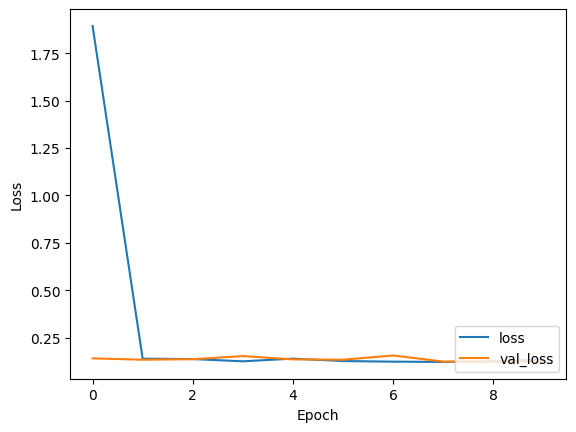

In [28]:
#make a plot for loss
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

198/198 [==============================] - 3s 13ms/step


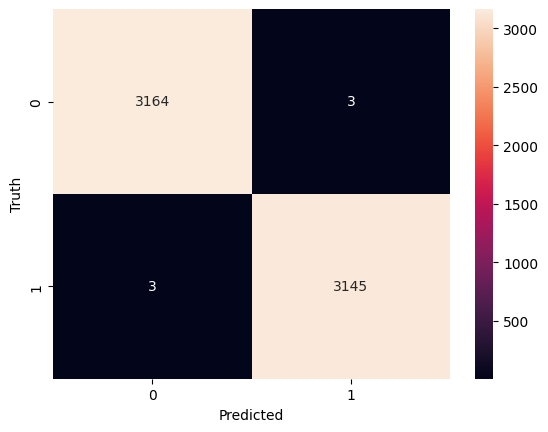

In [29]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = lstm_model1.predict(X_test_pad)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [40]:
import pandas as pd
from nltk.tokenize import word_tokenize
import numpy as np
def process_csv(file_path):
    df = pd.read_csv(file_path, encoding='latin1')  # Specify the encoding parameter
    feature_names = df.columns.tolist()
    return feature_names
def process_txt(file_path):
    with open(file_path, 'r', encoding='latin1') as file:  # Specify the encoding parameter
        text = file.read()
    tokens = word_tokenize(text)
    return tokens
def process_file(file_path):
    if file_path.endswith('.csv'):
        feature_names = process_csv(file_path)
        return feature_names
    elif file_path.endswith('.txt'):
        tokens = process_txt(file_path)
        return tokens
    elif file_path.endswith('.json'):
        # Add your code to process JSON files here
        pass
    else:
        print("Unsupported file format.")
# Get the file path from the user
file_path = input("Enter the path of the file: ")
# Process the file
features = process_file(file_path)
data_array = np.array(features)

data_input = data_array.reshape(1, -1)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(features)

# Encoding
sequences = tokenizer.texts_to_sequences(features)

# Find the length of the longest sequence
max_length = max(len(sequence) for sequence in sequences)

data_input = pad_sequences(sequences, maxlen=max_length)

# Make predictions using the model
preds = lstm_model1.predict(data_input)

# Print the predictions
print(preds)
sensitive=[]
for i in range(len(preds)):
  print(preds[i][0])
  if preds[i][0]>0.5:
    sensitive.append(features[i])
    print("Sensitive - "+ features[i])
  else:
    print("Non-Sensitive - " + features[i] )

1/1 [==============================] - 0s 32ms/step
[[0.5213012 ]
 [0.5354406 ]
 [0.5354058 ]
 [0.5353804 ]
 [0.529417  ]
 [0.50769204]
 [0.49530303]
 [0.5310646 ]
 [0.524055  ]
 [0.5245797 ]
 [0.5226264 ]
 [0.52403057]
 [0.5295879 ]]
0.5213012
Sensitive - Person ID
0.5354406
Sensitive - Gender
0.5354058
Sensitive - Age
0.5353804
Sensitive - Occupation
0.529417
Sensitive - Sleep Duration
0.50769204
Sensitive - Quality of Sleep
0.49530303
Non-Sensitive - Physical Activity Level
0.5310646
Sensitive - Stress Level
0.524055
Sensitive - BMI Category
0.5245797
Sensitive - Blood Pressure
0.5226264
Sensitive - Heart Rate
0.52403057
Sensitive - Daily Steps
0.5295879
Sensitive - Sleep Disorder


In [42]:
df=pd.DataFrame(sensitive,columns=['Sensitive'])

In [41]:
df=pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')

In [43]:
from cryptography.fernet import Fernet  
df_sen = df
# Generate a key
key = Fernet.generate_key()
# Save the key to a file
with open("key.key", "wb") as key_file:
    key_file.write(key)
# Load the key from the file
with open("key.key", "rb") as key_file:
    key = key_file.read()
# Create a cipher suite
cipher_suite = Fernet(key)
# Encrypt the data
cipher_text = cipher_suite.encrypt(df_sen.to_csv().encode())
# Save the encrypted data to a file
with open("whole.csv.encrypted", "wb") as file:  
    file.write(cipher_text)
print("Data Encrypted and Saved")
# Load the encrypted data from the file
with open("whole.csv.encrypted", "rb") as file:
    cipher_text = file.read()
# Decrypt the data
plain_text = cipher_suite.decrypt(cipher_text)
# Save the decrypted data to a file
with open("wholw.csv.decrypted", "wb") as file:
    file.write(plain_text)
print("Data Decrypted and Saved")
# Save the model
lstm_model1.save("model.h5")
print("Model Saved")

Data Encrypted and Saved
Data Decrypted and Saved
Model Saved


c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
test = ['Hi Paul, would you come around tonight']
seq = tokenizer.texts_to_sequences(test)

pad = pad_sequences(seq, maxlen=20, padding='post')
tokenizer.index_word
pad
pred = lstm_model1.predict(pad)
# print the class label
if pred > 0.5:
    print('Sensitive')
else:
    print('Non-sensitive')

1/1 [==============================] - 0s 23ms/step
Non-sensitive


In [42]:
test = ["My social security number is 123-45-6789.",
"My credit card number is 1234 5678 9012 3456.",
"My email address is john.doe@gmail.com.",
"My phone number is (123) 456-7890.",
"I live at 123 Main St, Anytown, USA.",
"I love to play soccer on the weekends.",
"My favorite color is blue.",
"The weather is really nice today.",
"I have a pet dog named Rover.",
'Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results']
for i in test:
    seq = tokenizer.texts_to_sequences([i])
    pad = pad_sequences(seq, maxlen=20, padding='post')
    max_num=max([max(seq) for seq in pad])
    pred = lstm_model1.predict(pad)
    if pred > 0.5:
        print(i, 'Sensitive')
    else:
        print(i, 'Non-sensitive')

1/1 [==============================] - 0s 23ms/step
My social security number is 123-45-6789. Sensitive
1/1 [==============================] - 0s 27ms/step
My credit card number is 1234 5678 9012 3456. Sensitive
1/1 [==============================] - 0s 21ms/step
My email address is john.doe@gmail.com. Sensitive
1/1 [==============================] - 0s 24ms/step
My phone number is (123) 456-7890. Sensitive
1/1 [==============================] - 0s 23ms/step
I live at 123 Main St, Anytown, USA. Non-sensitive
1/1 [==============================] - 0s 24ms/step
I love to play soccer on the weekends. Non-sensitive
1/1 [==============================] - 0s 26ms/step
My favorite color is blue. Sensitive
1/1 [==============================] - 0s 25ms/step
The weather is really nice today. Non-sensitive
1/1 [==============================] - 0s 22ms/step
I have a pet dog named Rover. Non-sensitive
1/1 [==============================] - 0s 26ms/step
Name Sensitive
1/1 [========================

In [22]:
from keras.regularizers import l1
from keras.constraints import max_norm
lstm_model2 = Sequential()
lstm_model2.add(Embedding(max_num+1,64, input_length=20))
lstm_model2.add(LSTM(200,return_sequences=True,kernel_regularizer=l1(0.01),kernel_constraint=max_norm(2.)))
lstm_model2.add(LSTM(200,kernel_regularizer=l1(0.01),kernel_constraint=max_norm(2.)))
lstm_model2.add(Dense(1, activation='sigmoid'))

lstm_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 64)            5223936   
                                                                 
 lstm_1 (LSTM)               (None, 20, 200)           212000    
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 5756937 (21.96 MB)
Trainable params: 5756937 (21.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
history2 = lstm_model2.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/10
395/395 [==============================] - 99s 218ms/step - loss: 6.3018 - accuracy: 0.9847 - val_loss: 0.2506 - val_accuracy: 0.9992
Epoch 2/10
395/395 [==============================] - 89s 224ms/step - loss: 0.4611 - accuracy: 0.9971 - val_loss: 0.3491 - val_accuracy: 0.9962
Epoch 3/10
395/395 [==============================] - 92s 232ms/step - loss: 0.2535 - accuracy: 0.9993 - val_loss: 0.2407 - val_accuracy: 0.9970
Epoch 4/10
395/395 [==============================] - 85s 215ms/step - loss: 0.2557 - accuracy: 0.9992 - val_loss: 0.2452 - val_accuracy: 0.9976
Epoch 5/10
395/395 [==============================] - 87s 220ms/step - loss: 0.2335 - accuracy: 0.9998 - val_loss: 0.3371 - val_accuracy: 0.9940
Epoch 6/10
395/395 [==============================] - 89s 226ms/step - loss: 0.2480 - accuracy: 0.9996 - val_loss: 0.2532 - val_accuracy: 0.9965
Epoch 7/10
395/395 [==============================] - 85s 215ms/step - loss: 0.2300 - accuracy: 0.9998 - val_loss: 0.2370 - val_ac

In [24]:
test_loss, test_acc = lstm_model2.evaluate(X_test_pad, y_test, verbose=2)


198/198 - 10s - loss: 0.2718 - accuracy: 0.9967 - 10s/epoch - 49ms/step


In [25]:
from keras.regularizers import l1
from keras.constraints import max_norm
lstm_model3 = Sequential()
lstm_model3.add(Embedding(max_num+1,64, input_length=20))
lstm_model3.add(LSTM(300,kernel_regularizer=l1(0.001),kernel_constraint=max_norm(2.)))
lstm_model3.add(Dense(1, activation='sigmoid'))

lstm_model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 64)            5223936   
                                                                 
 lstm_3 (LSTM)               (None, 300)               438000    
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 5662237 (21.60 MB)
Trainable params: 5662237 (21.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
history3 = lstm_model3.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/10
395/395 [==============================] - 77s 168ms/step - loss: 0.2857 - accuracy: 0.9878 - val_loss: 0.0208 - val_accuracy: 0.9995
Epoch 2/10
395/395 [==============================] - 67s 169ms/step - loss: 0.0207 - accuracy: 0.9993 - val_loss: 0.0223 - val_accuracy: 0.9994
Epoch 3/10
395/395 [==============================] - 66s 168ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.1153 - val_accuracy: 0.9884
Epoch 4/10
395/395 [==============================] - 70s 178ms/step - loss: 0.0107 - accuracy: 0.9999 - val_loss: 0.0746 - val_accuracy: 0.9997
Epoch 5/10
395/395 [==============================] - 70s 178ms/step - loss: 0.0150 - accuracy: 0.9998 - val_loss: 0.0158 - val_accuracy: 0.9984
Epoch 6/10
395/395 [==============================] - 75s 189ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 0.9984
Epoch 7/10
395/395 [==============================] - 67s 170ms/step - loss: 0.0581 - accuracy: 0.9997 - val_loss: 0.4662 - val_ac

In [27]:
test_loss, test_acc = lstm_model3.evaluate(X_test_pad, y_test, verbose=2)

198/198 - 7s - loss: 0.0311 - accuracy: 0.9968 - 7s/epoch - 36ms/step
